# Creating road network, shortening edges, connecting colume
*Author: Filip Moen Nilsen*

This Jupyter notebook uses geodata of the Norwegian road network to construct a comprehensive network represented in a NetworkX graph. <br>
The network is enriched by incorporating gradient information, and a range of computational statistics are applied.<br> However, the complete network is large and complex, with an abundance of nodes and edges. <br>
To address this, a simplification process is implemented, and the results and statistics of this simplification are compared to those of the original network. <br> 
After the network is simplified, the notebook proceeds to assign traffic points to edges throughout the Norwegian road network,<br> with each edge assigned a corresponding monthly traffic volume for the year 2018.

Import necessary packages:

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns 
import geopandas as gpd
import pandas as pd 
import numpy as np
import requests
import shapely
import pickle
import progressbar
import geopy.distance
import geopandas as gpd
import pyproj
import os
import matplotlib.cm as cm
import matplotlib.colors as colors
import itertools
import warnings
import random
import timeit
import time
import threading
#import functions
from joblib import Parallel, delayed
#from functions import *
from shapely.geometry import Point, Polygon, LineString 
from shapely.ops import nearest_points
from shapely.ops import transform
from shapely import geometry, ops
from functools import partial
from itertools import combinations
from multiprocessing import Pool
from random import choice, randint
from scipy.sparse import lil_matrix
warnings.simplefilter('ignore')

#from networkFuncs import build_network_data #, get_edge_attributes #, shorten_edges_v2

# Display all columns in the df
pd.set_option('display.max_columns', None)
# Set the float format to display numbers in standard decimal notation
pd.options.display.float_format = '{:.5f}'.format

Import ruttgerlink, OD-pairs, CS´s and traffic-points:

In [2]:
# Import network data from statens vegvesen
ruttger_link_geom = gpd.read_file('/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/1_DataToFinalNetwork/ruttgerlink03_woZ.geojson')
crs_name = 'epsg:4326'
ruttger_link_geom['length'] = ruttger_link_geom['geometry'].length
# Read OD Nodes and All current ChargingStationsNodes
OD = pd.read_csv("/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/1_DataToFinalNetwork/OD_new.csv", encoding="Cp1252")
OD = OD.drop('Unnamed: 0', axis=1)
# Read Current Charging Stations
CS = pd.read_csv("/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/1_DataToFinalNetwork/AllCurrentCS.csv", encoding="Cp1252")
CS = CS.drop('Unnamed: 0', axis=1)
# Read the GeoJSON file containing traffic points. 
trafficPoints_df = gpd.read_file('/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/1_DataToFinalNetwork/points_alone_all.geojson')
trafficPoints_gdf = gpd.GeoDataFrame(trafficPoints_df, geometry="geometry", crs='EPSG:4326')

# Display dataframes if necessary
#display(ruttger_link_geom.head())
#display(OD.head())
#display(CS.head())
#display(trafficPoints_df.head())

In [3]:
# Transform project into lat-long coordinate system (ESPG:4326)
project = pyproj.Transformer.from_proj(
    pyproj.Proj(init='epsg:8687'), # source coordinate system
    pyproj.Proj(init='epsg:4326')) # destination coordinate system

ruttger_link_geom['geometry'] = ruttger_link_geom['geometry'].apply(lambda x: transform(project.transform, x))

## Build Norwegian Road Network

### def build_network_data
*By: Samuel Berntzen.* <br>
*Github: https://github.com/samuelberntzen/Optimal-Allocation-of-Electric-Vehicle-Charging-Stations-A-case-study-of-the-Norwegian-road-network*

In [8]:
def build_network_data(GeoData):    
    """
    Returns node-dict and edge-dict which is networkx compatible network from Vegvesenets routable data available at https://kartkatalog.geonorge.no/metadata/statens-vegvesen/nvdb-ruteplan-nettverksdatasett/8d0f9066-34f9-4423-be12-8e8523089313 
    """

    # Get unique nodes
    nodes = {}

    print("Beginning tonodes...")
    for i in GeoData.drop_duplicates('tonode').index:

        # Get node ID for filtering duplicates
        _id          = GeoData.iloc[i]['tonode']

        # Only keep unique observations
        if _id not in nodes:
            # Get attributes if applicable, else get centroid coordinate in linestring (error usually indicate roundabout as one edge)
            try:
                x        = GeoData.iloc[i]['geometry'].boundary[-1].x
                y        = GeoData.iloc[i]['geometry'].boundary[-1].y
                roadclass = int(GeoData.iloc[i]['funcroadclass'])
                isBridge = int(GeoData.iloc[i]['isbridge'])
                isTunnel = int(GeoData.iloc[i]['istunnel'])
                geometry = Point(x,y)
            except Exception as e:
                x        = GeoData.iloc[i]['geometry'].centroid.x
                y        = GeoData.iloc[i]['geometry'].centroid.y
                roadclass = int(GeoData.iloc[i]['funcroadclass'])
                isBridge = int(GeoData.iloc[i]['isbridge'])
                isTunnel = int(GeoData.iloc[i]['istunnel'])
                geometry = Point(x,y)

            # Save and append
            content = {'x':x,'y':y,'osmid':_id, 'roadclass': roadclass, 'isBridge': isBridge, 'isTunnel': isTunnel, 'geometry':geometry}
            nodes[_id] = content
        else:
            pass

    # DO SIMILAR FOR FROMNODE:
    print("Beginning fromnodes...")
    for i in GeoData.drop_duplicates('fromnode').index:
            # Get node ID for filtering duplicates
        _id         = GeoData.iloc[i]['fromnode']

        # Only keep unique observations
        if _id not in nodes:
            # Get attributes if applicable, else get random coordinate in linestring (error usually indicate roundabout as one edge)
            try:
                x        = GeoData.iloc[i]['geometry'].boundary[-1].x
                y        = GeoData.iloc[i]['geometry'].boundary[-1].y
                roadclass = int(GeoData.iloc[i]['funcroadclass'])
                # isBridge = int(GeoData.iloc[i]['isbridge'])
                # isTunnel = int(GeoData.iloc[i]['istunnel'])
                geometry = Point(x,y)
            except Exception as e:
                x        = GeoData.iloc[i]['geometry'].centroid.x
                y        = GeoData.iloc[i]['geometry'].centroid.y
                roadclass = int(GeoData.iloc[i]['funcroadclass'])
                isBridge = int(GeoData.iloc[i]['isbridge'])
                isTunnel = int(GeoData.iloc[i]['istunnel'])
                geometry = Point(x,y)

            # Save and append
            content = {'x':x,'y':y,'osmid':_id, 'roadclass': roadclass, 'isBridge': isBridge, 'isTunnel': isTunnel, 'geometry':geometry}
            nodes[_id] = content
        else:
            pass


    # Get edges into networkx format
    edges = {}
    print("Beginning edges...")
    for i in GeoData.index:
        # Lets keep edges undirected for now (not one way)
        # Get edge ID for filtering duplicates:
        _id                 = GeoData.iloc[i]['linkid']

        # Get only data of edges not already retrieved
        if _id not in edges:
            ref                 = GeoData.iloc[i]['streetname'] 
            funcroadclass       = GeoData.iloc[i]['funcroadclass']
            roadclass           = GeoData.iloc[i]['roadclass']
            #roadtype            = GeoData.iloc[i]['roadtype']
            isFerry             = GeoData.iloc[i]['isferry']
            isBridge            = GeoData.iloc[i]['isbridge']
            isTunnel            = GeoData.iloc[i]['istunnel']
            speedlim            = GeoData.iloc[i]['speedfw']
            drivetime           = GeoData.iloc[i]['drivetime_fw']
            oneway              = False if GeoData.iloc[i]['oneway'] == "B" else False
            geometry            = GeoData.iloc[i]['geometry']
            u                   = GeoData.iloc[i]['fromnode']
            v                   = GeoData.iloc[i]['tonode']
            key                 = 0

            # linestring_trans = transform(project, GeoData.iloc[i]['geometry'])
            length = GeoData.iloc[i]['length'] - isFerry * GeoData.iloc[i]['length']
            length_weight = length.copy()

            # Estimate length based on speedlimit and drivetime
            # length_estimated = speedlim*drivetime*1000/60

            # Create dictionary of node data:
            content = {'id':_id, 'oneway':oneway, 'ref':ref, 'name':ref, 'funcroadclass':funcroadclass, 'roadclass':roadclass, 'isFerry':isFerry, 'isBridge':isBridge, 'isTunnel':isTunnel, 'speedlim':speedlim, 'drivetime':drivetime, 'length':length, 'length_weight':length_weight, 'geometry':geometry,'u':u, 'v':v, "key": key}
#            content = {'id':_id, 'oneway':oneway, 'ref':ref, 'name':ref, 'funcroadclass':funcroadclass, 'roadclass':roadclass, 'isFerry':isFerry, 'isBridge':isBridge, 'isTunnel':isTunnel, 'speedlim':speedlim, 'drivetime':drivetime, 'length':length, 'length_weight':length_weight, 'geometry':geometry,'u':u, 'v':v, "key": key}

            edges[(u,v,0)] = content
        else:
            pass 

    # Set crs system
    crs = {'init': crs_name}

    # Create for nodes
    nodes_df = pd.DataFrame.from_dict(nodes)
    nodes_df = nodes_df.T
    nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry="geometry")
    #nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry="geometry", crs="EPSG:4326").T
    #nodes_gdf = gpd.GeoDataFrame(nodes_df, crs = crs).T
    #nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=nodes_df['geometry'])

    # Create for edges
    edges_df = pd.DataFrame.from_dict(edges)
    edges_df = edges_df.T
    edges_gdf = gpd.GeoDataFrame(edges_df, geometry="geometry")
    #edges_gdf = gpd.GeoDataFrame(edges_df, geometry="geometry", crs="EPSG:4326").T
    #edges_gdf = gpd.GeoDataFrame(nodes_df, crs = crs).T
    #edges_gdf = gpd.GeoDataFrame(edges_df, geometry=edges_df['geometry'])

    return nodes_gdf, edges_gdf

In [9]:
BaseNodes_gdf, BaseEdges_gdf = build_network_data(ruttger_link_geom)

Beginning tonodes...
Beginning fromnodes...
Beginning edges...


In [10]:
# Setting graph attributes, and convert geodataframes to networkx array
graph_attrs = {'crs': 'epsg:4326', 'simplified': False}
G = ox.graph_from_gdfs(BaseNodes_gdf, BaseEdges_gdf.drop('key', axis = 1), graph_attrs = graph_attrs)

# Only keep mainland, irrelevant as O-D Nodes are applied.
start_node = ox.nearest_nodes(G, X = 59.9098, Y = 10.7146)
F = G.subgraph(nx.shortest_path(G.to_undirected(), start_node)) 

In [9]:
H = F.copy()
H = H.to_undirected()
# nx.write_gpickle(H, "Data/unsimp.gpickle") #Save sunplified 

### Displaying Network & some statistics

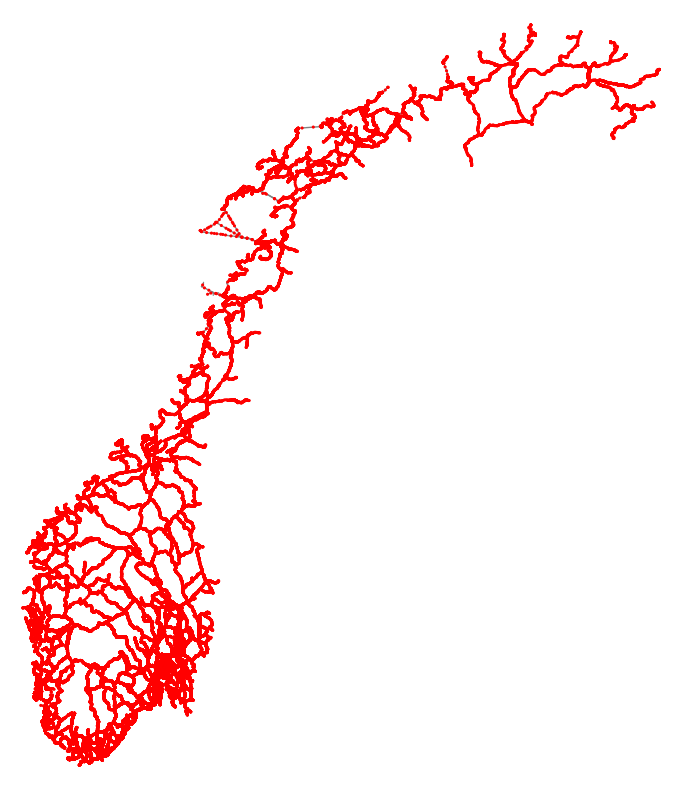

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot: >)

In [10]:
ox.plot_graph(H, figsize = (10, 10), node_color="red", edge_color = "gray", bgcolor = "white", node_size=5, edge_linewidth = 1)

In [11]:
print('There are a lot of nodes and edges in the graph - to many for our purpose. Note you can barely see the edges.')
print('Number of nodes:', len(H.nodes))
print('Number of edges:', len(H.edges))

There are a lot of nodes and edges in the graph - to many for our purpose. Note you can barely see the edges.
Number of nodes: 206514
Number of edges: 215120


### Adding gradient to graph + some data formatting for the simplification part

In [12]:
# Retrieve elevation of each node and grade of edges (You'll need your own Google Cloud Console API for this)
GOOGLE_API = ("ENTER API KEY HERE.")
H_elev = ox.elevation.add_node_elevations_google(F, api_key = GOOGLE_API)
H_elev = ox.elevation.add_edge_grades(H_elev)

# Copy H_elev
H = H_elev.copy()

for i in H.edges:
    grade = H.edges[i]['grade']
    if grade == float('inf'):
        # print("grade is inf")
        H.edges[i]['grade'] = 0
    if grade == float('-inf'):
        # print("grade is -inf")
        H.edges[i]['grade'] = 0
    if np.isnan(grade):
        # print("grade is nan")
        H.edges[i]['grade'] = 0

# Convert roadclass to int, because simplification appends it to list
for i in H.edges:
    data = H.edges[i]
    roadclass = data['funcroadclass']
    if type(roadclass) == list:
        # Keep minimum roadclass
        roadclass = min(roadclass)
    data['funcroadclass'] = roadclass

## Graph Simplification

In [11]:
H = F.copy()

#Get nearest node to each O-D location
lat = list(OD.lat)
lon = list(OD.lon)
ODs= ox.nearest_nodes(H, X = lon, Y = lat)
OD['node'] = ODs

#Get nearest node to each CS
latA = list(CS.Latitude)
lonA = list(CS.Longitude)
AllCSnodes = ox.nearest_nodes(H, X = lonA, Y = latA)
CS['node']=AllCSnodes
AllCSnodes1 = list(CS.node)
#Create combinations of O-D pairs. Used for several functions later on
combos = combinations(ODs,2)
OD_pairs = []
for i in combos:
    OD_pairs.append(list(i))

### def shorten_edges_v2 & def get_edge_attributes
*By: Alexander Aperatinos.* <br>
*Github: https://github.com/aperatinos/Optimal-Location-of-Electric-Vehicle-Charging-Stations-in-Norway-using-the-FLRM*

In [5]:
def get_edge_attributes(cumlist):
    
    
    """
    Function that takes a list of network nodes and merge their attributes as the different attributes need to be treated and formatted differently. This specifically applies for LineString.
    
    Input:
    cumlist: Cummulative list of nodes
    
    """

    cumlength = len(cumlist)
    path_attributes = dict()
    attrs_to_sum = {"length", "drivetime",}
    attrs_to_set = {'oneway', 'ref', 'name', 'funcroadclass', 'roadclass'}
    dummy_attrs = {'isFerry', 'isTunnel', 'isBridge'}
    nodes_to_remove = []
    
    for i in range(cumlength-1):
        u = cumlist[i]
        v = cumlist[i+1]
        edge_data = H.edges[u, v,0]

        for attr in edge_data:
            if attr in path_attributes:
            # if this key already exists in the dict, append it to the value list
                path_attributes[attr].append(edge_data[attr])
            else:
            # if this key doesn't already exist, set the value to a list containing the one value
                path_attributes[attr] = [edge_data[attr]]

    for attr in path_attributes:
        if attr == 'grade' or attr == 'length_weight':
            path_attributes[attr] = list(path_attributes[attr]) 
        elif attr in dummy_attrs:
            #If attribute is isFerry, isBridge og isTunnel, returns the value for first and last edge as these are candidate locations.
            if type(path_attributes[attr][0]) == list and type(path_attributes[attr][-1]) == list:
                fromnode = path_attributes[attr][0][0]
                tonode = path_attributes[attr][-1][-1]
                
            elif type(path_attributes[attr][0]) != list and type(path_attributes[attr][-1]) != list:
                fromnode = path_attributes[attr][0]
                tonode = path_attributes[attr][-1]
                
            elif type(path_attributes[attr][0]) == list and type(path_attributes[attr][-1]) != list:
                fromnode = path_attributes[attr][0][0]
                tonode = path_attributes[attr][-1]
                
            elif type(path_attributes[attr][0]) != list and type(path_attributes[attr][-1]) == list:
                fromnode = path_attributes[attr][0]
                tonode = path_attributes[attr][-1][-1]
            path_attributes[attr] = list((fromnode, tonode))

        elif attr in attrs_to_sum:
            # if this attribute must be summed, sum it now
            path_attributes[attr] = sum(path_attributes[attr])

        elif attr == 'id':
            path_attributes[attr] = list((cumlist[0],cumlist[-1]))

        
        elif attr == 'geometry':
                path_attributes[attr] = ops.linemerge(path_attributes[attr])
                
        elif attr == 'oneway':
            path_attributes[attr] = 'False'


        else:
        # otherwise, if there are multiple values, keep one of each
            try:
                path_attributes[attr] = list(set(path_attributes[attr]))
            except TypeError:
                try:
                    path_attributes[attr] = list(set(path_attributes[attr][0]))
                except:
                    path_attributes[attr] = path_attributes[attr]
            
    path_attributes['artificial'] = 1
    return path_attributes

In [6]:
def shorten_edges_v2(G, OD, cutoff):
    
    """
    Simplifies the edges in the network in order to make the runtimes of the GA/greedy substitution feassible. Depending on the threshold value, the function will remove all nodes/edges within a certain range, store and merge
    their attributes, before creating a new edge between the first and last node in the specified range. If threshol is for example 50000, the function will remove all nodes except the first and last node for every 50th km and 
    create a new edge between the first and last node. This i then repeated for each path between each OD pair.
    
    There are also certain statements to make sure that the same nodes are used if several paths intersect. This usually happens when multiple routes shares the same path. 
    
    Input:
    G: Networkx Multigraph
    OD: CSV file with coordinates of each OD location in Norway
    Threshold: Cutoff in meters at which edges at merged. 
    """

    
    #Create flat list of O-D pairs
    OD_pairs_flat = [item for sublist in OD_pairs for item in sublist]
    
    #Create empty MultiGraph
    B = nx.MultiGraph(crs='epsg:4326')
    
    #Initialize progressbar to monitor progress of function while running.
    maxval = len(OD_pairs)
    bar    = progressbar.ProgressBar(maxval=maxval, \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    counter=0
    bar.start()

    UsedNodes = []
    for i in OD_pairs:
        fromOD = i[0]
        toOD = i[1]
        path = None
        try:
            path = nx.shortest_path(H, fromOD, toOD, 'length')
            pathlength = len(path)
            lengthofpath = nx.shortest_path_length(H, fromOD, toOD, 'length')
            cumlength = 0
            cumlist = []
            cutoff = cutoff
        except Exception as e:
            #print(f"An error occurred while calculating shortest path for {fromOD} -> {toOD}: {e}")
            continue


        #for each in edge in path[i]
        for i in range(pathlength-1):
            fromnode = path[i]
            tonode = path[i+1]
            templength = H.edges[fromnode, tonode, 0]['length']

            cumlist.append(fromnode)
            cumlist.append(tonode)
            cumlength += templength

            #First check if tonode already exists in B. If it does, it means that a previously created path has used same route. 
            #In this case we want to use existing nodes on path rather than creating new ones.
            if tonode in UsedNodes:
                #If edge does not exist, then add it
                if B.has_edge(cumlist[0], cumlist[-1]) is False:
                    cumlist = list(dict.fromkeys(cumlist))
                    #Get attributes for nodes and edge to add
                    fnodeattr = H.nodes[cumlist[0]]
                    tnodeattr = H.nodes[cumlist[-1]]
                    edgeattr = get_edge_attributes(cumlist)

                    #Add nodes and edge
                    B.add_node(cumlist[0], **fnodeattr)
                    B.add_node(cumlist[-1], **tnodeattr)
                    B.add_edge(cumlist[0], cumlist[-1], **edgeattr)

                    #Added nodes are appended to all UsedNodes
                    UsedNodes.append(cumlist[0])
                    UsedNodes.append(cumlist[-1])
                    cumlist = []
                    cumlength = 0


                #Else, skip this part, but empty cummulative path and length
                else:
                    cumlist = []
                    cumlength = 0
                    pass
                
            elif tonode in AllCSnodes: #if next node is a CS node
                #If edge does not exist, then add it
                if B.has_edge(cumlist[0], cumlist[-1]) is False:
                    cumlist = list(dict.fromkeys(cumlist))
                    #Get attributes for nodes and edge to add
                    fnodeattr = H.nodes[cumlist[0]]
                    tnodeattr = H.nodes[cumlist[-1]]
                    edgeattr = get_edge_attributes(cumlist)

                    #Add nodes and edge
                    B.add_node(cumlist[0], **fnodeattr)
                    B.add_node(cumlist[-1], **tnodeattr)
                    B.add_edge(cumlist[0], cumlist[-1], **edgeattr)

                    #Added nodes are appended to all UsedNodes
                    UsedNodes.append(cumlist[0])
                    UsedNodes.append(cumlist[-1])
                    cumlist = []
                    cumlength = 0


                #Else, skip this part, but empty cummulative path and length
                else:
                    cumlist = []
                    cumlength = 0
                    pass
                

            #Next, check if tonode is an OD node. If it is we will create edge from start of cumlist to the OD node.
            elif tonode in OD_pairs_flat:
                #If edge does not exist, then add it
                if B.has_edge(cumlist[0], cumlist[-1]) is False:
                    cumlist = list(dict.fromkeys(cumlist))
                    #Get attributes for nodes and edge to add
                    fnodeattr = H.nodes[cumlist[0]]
                    tnodeattr = H.nodes[cumlist[-1]]
                    edgeattr = get_edge_attributes(cumlist)

                    #Add nodes and edge
                    B.add_node(cumlist[0], **fnodeattr)
                    B.add_node(cumlist[-1], **tnodeattr)
                    B.add_edge(cumlist[0], cumlist[-1], **edgeattr)

                    UsedNodes.append(cumlist[0])
                    UsedNodes.append(cumlist[-1])
                    cumlist = []
                    cumlength = 0
                #Else, skip this part, but empty cummulative path and length
                else:
                    cumlist = []
                    cumlength = 0
                    pass

            #Next, check if the cummulative length in path is higher than the set threshold. If it is we will create a new edge in B
            #Can consider adding an if inside here that check if there is a node within a certain radius, and skip if it is.
            #This could prevent that nodes on completely different paths are very close or that a node is set very close to an OD node. 
            #Would then find last element in cumlist in H and get lat,lon, then use ox nearest node to find nearest node in B and finally use geopy to find distance between them. 

            elif cumlength >= cutoff:            


                if B.has_edge(cumlist[0], cumlist[-1]) is False:
                    #Remove duplicates from cumlist
                    cumlist = list(dict.fromkeys(cumlist))
                    distanceOD = 100000
                    #Before we add new edge, check if destination node is within threshold/2
                    lat = H.nodes[cumlist[-1]]['y']
                    lon = H.nodes[cumlist[-1]]['x']
                    latlon = (lat,lon)
                    latdestination = H.nodes[toOD]['y']
                    londestination = H.nodes[toOD]['x']

                    #Also check if there is an already created node nearby
                    try:
                        potentialnode = ox.nearest_nodes(B, X = lat,Y = lon)
                        clatclon = (latdestination,londestination)
                        distanceOD = (geopy.distance.geodesic(latlon,clatclon).m)

                    except ValueError:
                        pass

                    # clatclon = (latdestination,londestination)
                    # distanceOD = (geopy.distance.geodesic(latlon,clatclon).m)
                    # distancepath = geopy.distance.geodesic(latlon, platplon).m

                    if distanceOD <= cutoff/2:
                        pass


                    else:
                        #Get attributes for nodes and edge to add
                        fnodeattr = H.nodes[cumlist[0]]
                        tnodeattr = H.nodes[cumlist[-1]]
                        edgeattr = get_edge_attributes(cumlist)

                        #Add nodes and edge
                        B.add_node(cumlist[0], **fnodeattr)
                        B.add_node(cumlist[-1], **tnodeattr)
                        B.add_edge(cumlist[0], cumlist[-1], **edgeattr)

                        UsedNodes.append(cumlist[0])
                        UsedNodes.append(cumlist[-1])                
                        cumlist = []
                        cumlength = 0

                #Else, skip this part, but empty cummulative path and length
                else:
                    cumlist = []
                    cumlength = 0
                    pass

        bar.update(counter)
        counter+=1

    bar.finish()

    #Set OD=1 for all O-D nodes and CS=1 for all current CS nodes. 
    nx.set_node_attributes(B, 0, 'OD')
    nx.set_node_attributes(B, 0, 'CS')

    attrs = {}
    for i in OD_pairs_flat:
        O = i
        attrs[i] = {'OD':1}
    nx.set_node_attributes(B, attrs)
    
    attrs = {}
    for i in AllCSnodes:
        O = i
        attrs[i] = {'CS':1}
    nx.set_node_attributes(B, attrs)
    
    
    print("Complete!")
    return B

***NOTE:*** *shorten_edges_v2 takes a while. Approximately 2 hours.*

In [16]:
M = H.copy()

In [12]:
B = shorten_edges_v2(P, OD, 10000) #Select cut-off value
#nx.write_gpickle(B,"Data/B10000.gpickle")
#B = shorten_edges_v2(H, OD, 2000)
#nx.write_gpickle(B,"Data/B2000.gpickle")
#B = shorten_edges_v2(H, OD, 5000)
#nx.write_gpickle(B,"Data/B5000.gpickle")

Complete!


In [18]:
M = B.copy() # Copy graph to 

### Display Simplified Graph

In [ ]:
ox.plot_graph(B, figsize = (10, 10), node_color="red", edge_color = "gray", bgcolor = "white", node_size=5, edge_linewidth = 1)

#Basic figure of network
node_color = []
for i in B.nodes:
    if B.nodes[i]['CS']==1:
            node_color.append('red')
    else:
        node_color.append('c')
ox.plot_graph(B, node_color=node_color, node_size=5)

Display simplified graph compared with original graph:

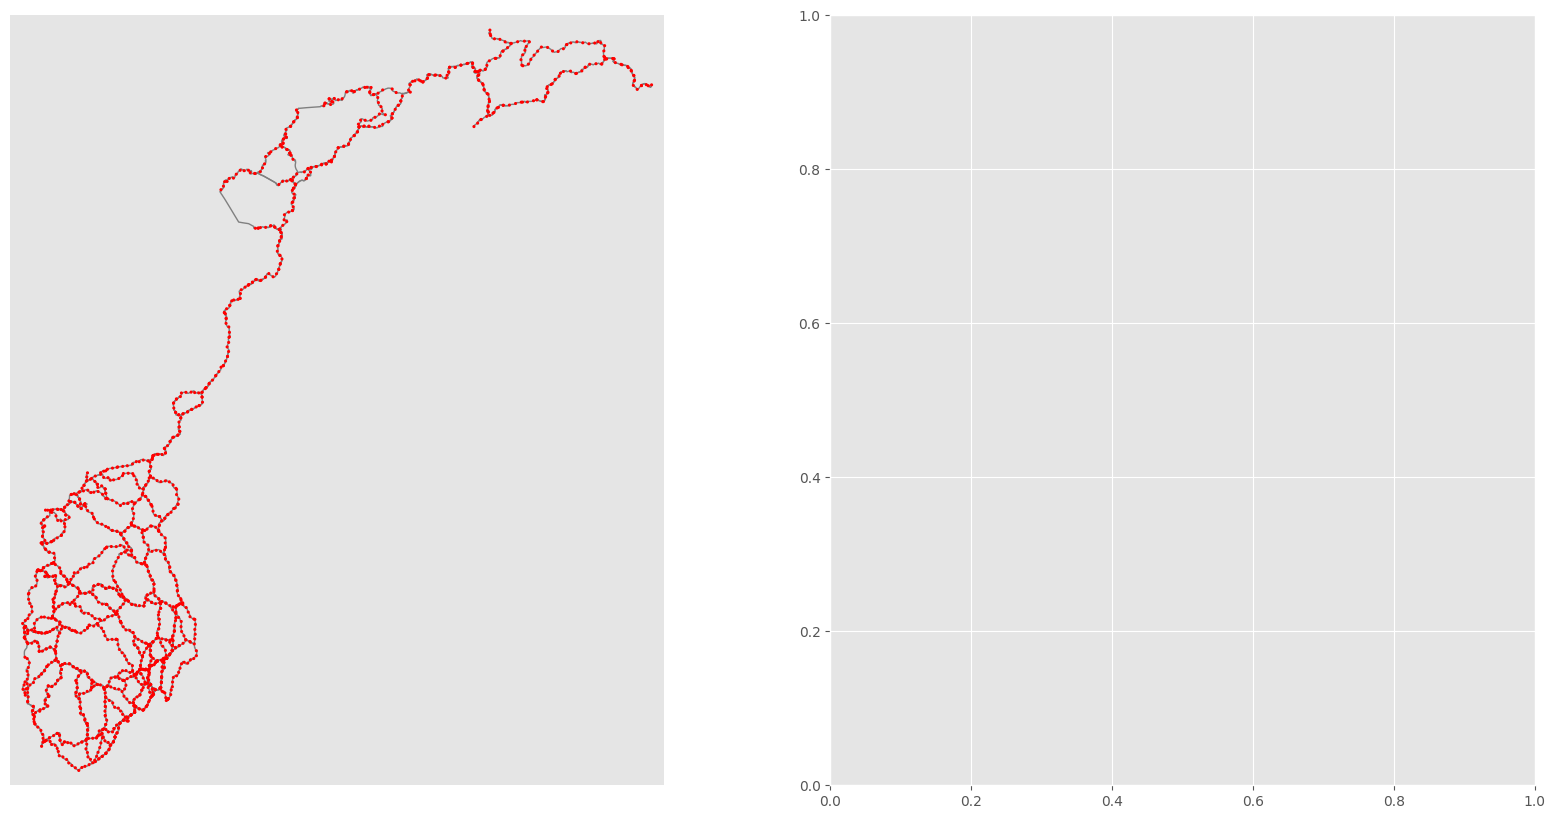

<Figure size 640x480 with 0 Axes>

Number of nodes in simplified graph: 1745
Number of edges simplified graph: 2377
 
Number of nodes in original graph: 206567
Number of edges original graph: 215164


In [130]:
# Plot simplified graph and original graph side-by-side:
fig, axs = plt.subplots(1, 2, figsize=(20, 10)) # create a figure with two subplots
ox.plot_graph(F, ax=axs[0], node_color="red", edge_color="gray", bgcolor="white", node_size=5, edge_linewidth=1) # plot F on the left subplot
ox.plot_graph(H, ax=axs[1], node_color="red", edge_color="gray", bgcolor="white", node_size=5, edge_linewidth=1) # plot H on the right subplot
axs[0].set_title("Simplified Graph") # set title for left subplot
axs[1].set_title("Original Graph") # set title for right subplot
plt.show() # display the plot

print('Number of nodes in simplified graph:', len(F.nodes))
print('Number of edges simplified graph:', len(F.edges))
print(' ')
print('Number of nodes in original graph:', len(H.nodes))
print('Number of edges original graph:', len(H.edges))

#### Converting graph to nodes and edges geodataframes

In [22]:
# Store node attributes in a dictionary
node_attrs = {}
for node, attrs in M.nodes(data=True):
    node_attrs[node] = attrs

# Create a DataFrame from the node attributes
node_df = pd.DataFrame.from_dict(node_attrs, orient='index')

# Convert the edge data to a pandas DataFrame
edge_data = M.edges(data=True)
edge_df = pd.DataFrame(edge_data, columns=['source', 'target', 'data_dict'])

# Extract the data into separate columns
edge_df = pd.concat([edge_df.drop('data_dict', axis=1), edge_df['data_dict'].apply(pd.Series)], axis=1)

# create geometry points from x and y columns
geometry = [Point(xy) for xy in zip(node_df['x'], node_df['y'])]
# add geometry column to dataframe
node_df['geometry'] = geometry
nodes_gdf = gpd.GeoDataFrame(node_df, geometry="geometry")
edges_gdf = gpd.GeoDataFrame(edge_df, geometry="geometry")

nodes_gdf.crs = {'init': 'epsg:4326'}
edges_gdf.crs = {'init': 'epsg:4326'}

#display(nodes_gdf)
#display(edges_gdf)

Save network as a Pickle-object:

In [ ]:
# Save as pickle object
#path = '/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/3_outputFromNetworkModelling'
#nx.write_gpickle(M.to_undirected(), path)

## Assign traffic points and volume to edges

In [6]:
# Import the simplified network from previous step:
with open("/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/1_DataToFinalNetwork/Simplified_ShortenEdgesv2.pickle", 'rb') as file:
    F = pickle.load(file)

In [7]:
# Store node attributes in a dictionary
node_attrs = {}
for node, attrs in F.nodes(data=True):
    node_attrs[node] = attrs

# Create a DataFrame from the node attributes
node_df = pd.DataFrame.from_dict(node_attrs, orient='index')

# Convert the edge data to a pandas DataFrame
edge_data = F.edges(data=True)
edge_df = pd.DataFrame(edge_data, columns=['source', 'target', 'data_dict'])

# Extract the data into separate columns
edge_df = pd.concat([edge_df.drop('data_dict', axis=1), edge_df['data_dict'].apply(pd.Series)], axis=1)

# create geometry points from x and y columns
geometry = [Point(xy) for xy in zip(node_df['x'], node_df['y'])]
# add geometry column to dataframe
node_df['geometry'] = geometry
nodes_gdf = gpd.GeoDataFrame(node_df, geometry="geometry")
edges_gdf = gpd.GeoDataFrame(edge_df, geometry="geometry")

nodes_gdf.crs = {'init': 'epsg:4326'}
edges_gdf.crs = {'init': 'epsg:4326'}

#display(nodes_gdf)
#display(edges_gdf)

Display Traffic Points On Map With The Simplified Graph

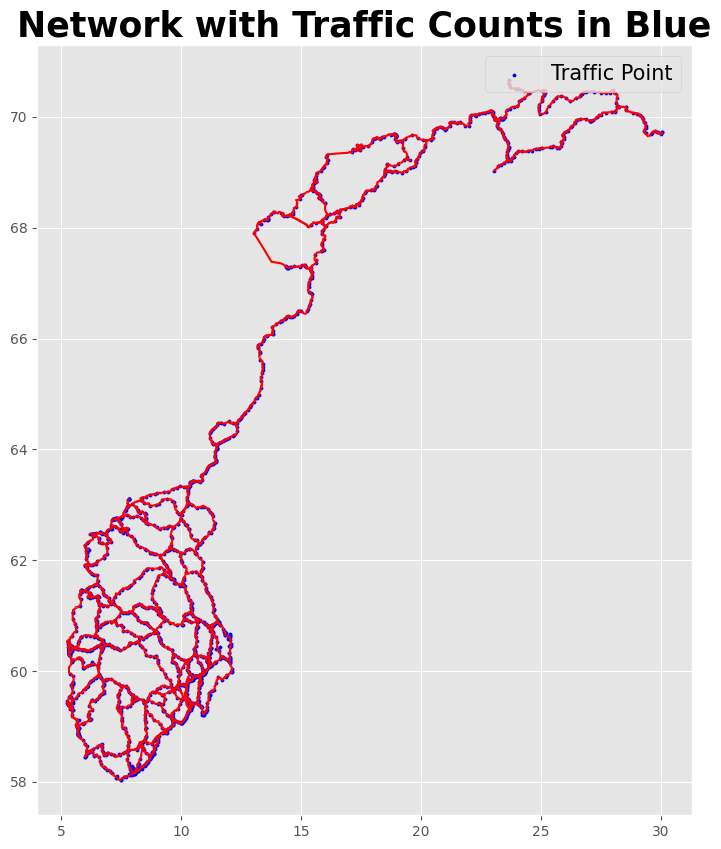

The traffic points are evenly distributed along the network.


In [8]:
# set style to default
plt.style.use('ggplot')

# set up the plot
fig, ax = plt.subplots(figsize=(15, 10))

edges_gdf.plot(ax=ax, color='red')
#nodes_gdf.plot(ax=ax, color='black', markersize=2)
trafficPoints_gdf.plot(ax=ax, color='blue', markersize=5, label='Traffic Point')
ax.legend(loc='upper right', fontsize=15) # Specify location and font size
ax.set_title('Network with Traffic Counts in Blue', fontweight='bold', fontsize=25)

# display the plot
plt.show()

print('The traffic points are evenly distributed along the network.')


### def assign_vol_to_edges() 
*This function assigns each edge its closest traffic point ID.* <br>
*By: Anton Olav Glad and Filip Moen Nilsen <br>*
*Github: https://github.com/AntonOlav/traffic-flow-maps*

In [106]:
def assign_vol_to_edges(points_df, N, threshold, exclude_edges=None):
    if exclude_edges is None:
        exclude_edges = []

    for idx, row in tqdm(points_df.iterrows(), total=points_df.shape[0]):
        point = row['geometry']
        nearest_node = None
        min_distance = float('inf')

        for node in N.nodes:
            x, y = N.nodes[node]['x'], N.nodes[node]['y']
            node_point = Point(x, y)
            distance = point.distance(node_point)
            if distance < min_distance:
                nearest_node = node
                min_distance = distance

        nearest_edge = None
        min_distance = float('inf')

        for edge in N.edges:
            if edge in exclude_edges:
                continue

            node1 = N.nodes[edge[0]]
            node2 = N.nodes[edge[1]]
            coords = [(node1['x'], node1['y']), (node2['x'], node2['y'])]
            distance = point.distance(LineString(coords))

            if distance < min_distance:
                nearest_edge = edge
                min_distance = distance

        if min_distance < threshold:
            edge_attrs = {}
            edge_attrs['trafficPoint_ID'] = row['id']
            N.edges[nearest_edge].update(edge_attrs)

100%|██████████| 2122/2122 [03:56<00:00,  8.98it/s]


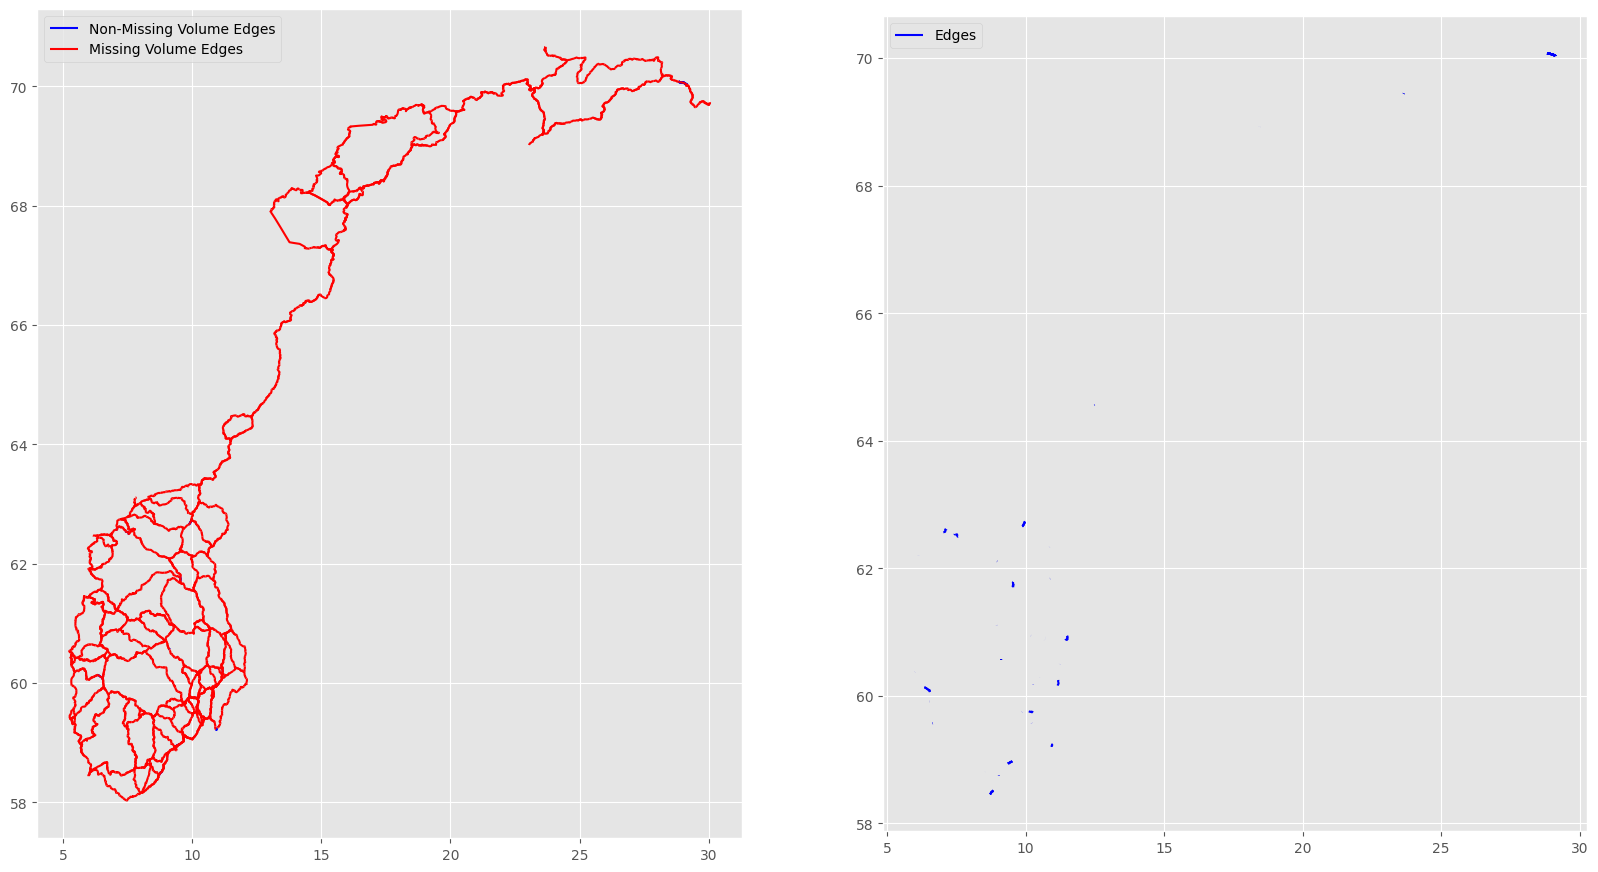

Edges with volume assigned after 1 loop(s) 37
Edges missing volume after 1 loop(s): 2340
Loop 1 threshold = 1e-05
--------------------------------------------------------------------------------


100%|██████████| 2122/2122 [04:01<00:00,  8.80it/s]


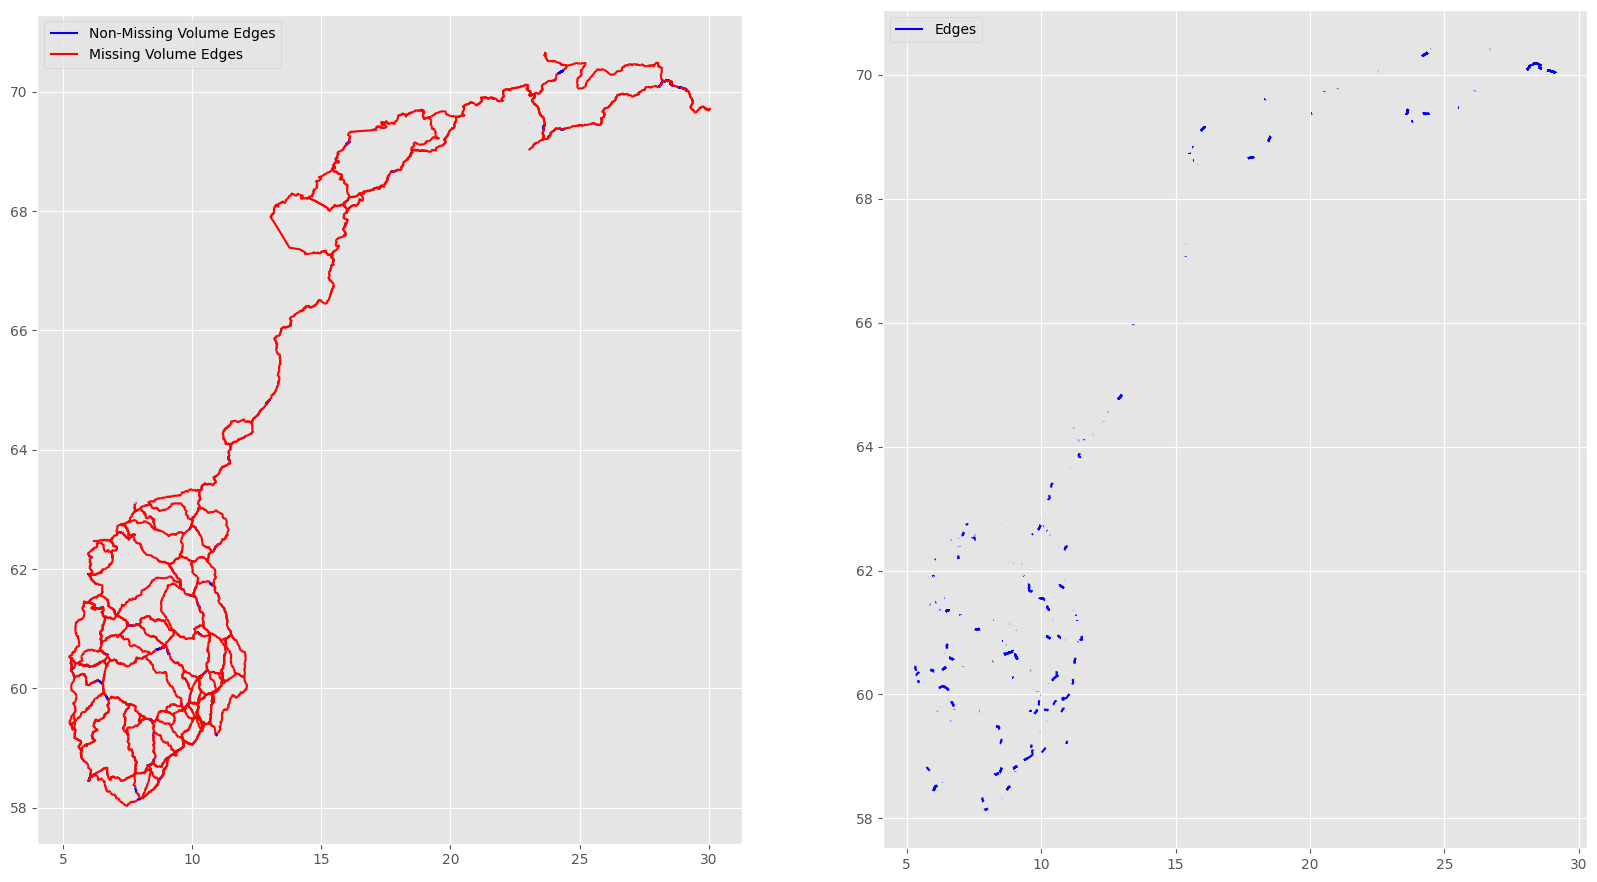

Edges with volume assigned after 2 loop(s) 210
Edges missing volume after 2 loop(s): 2167
Loop 2 threshold = 0.0001
--------------------------------------------------------------------------------


100%|██████████| 2122/2122 [03:58<00:00,  8.91it/s]


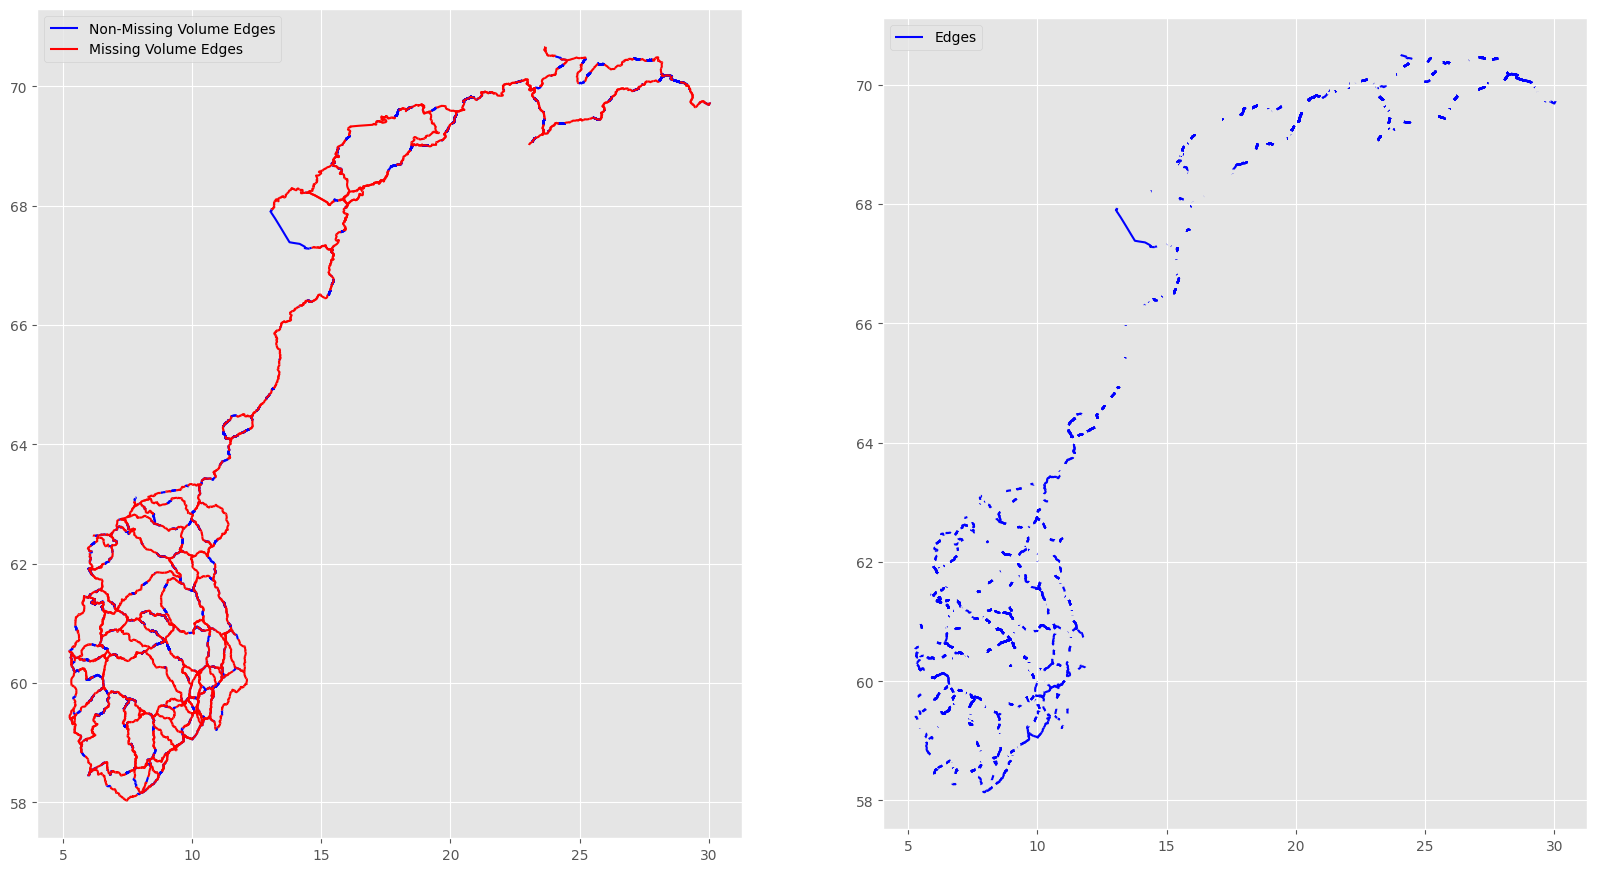

Edges with volume assigned after 3 loop(s) 693
Edges missing volume after 3 loop(s): 1684
Loop 3 threshold = 0.001
--------------------------------------------------------------------------------


100%|██████████| 2122/2122 [04:24<00:00,  8.02it/s]


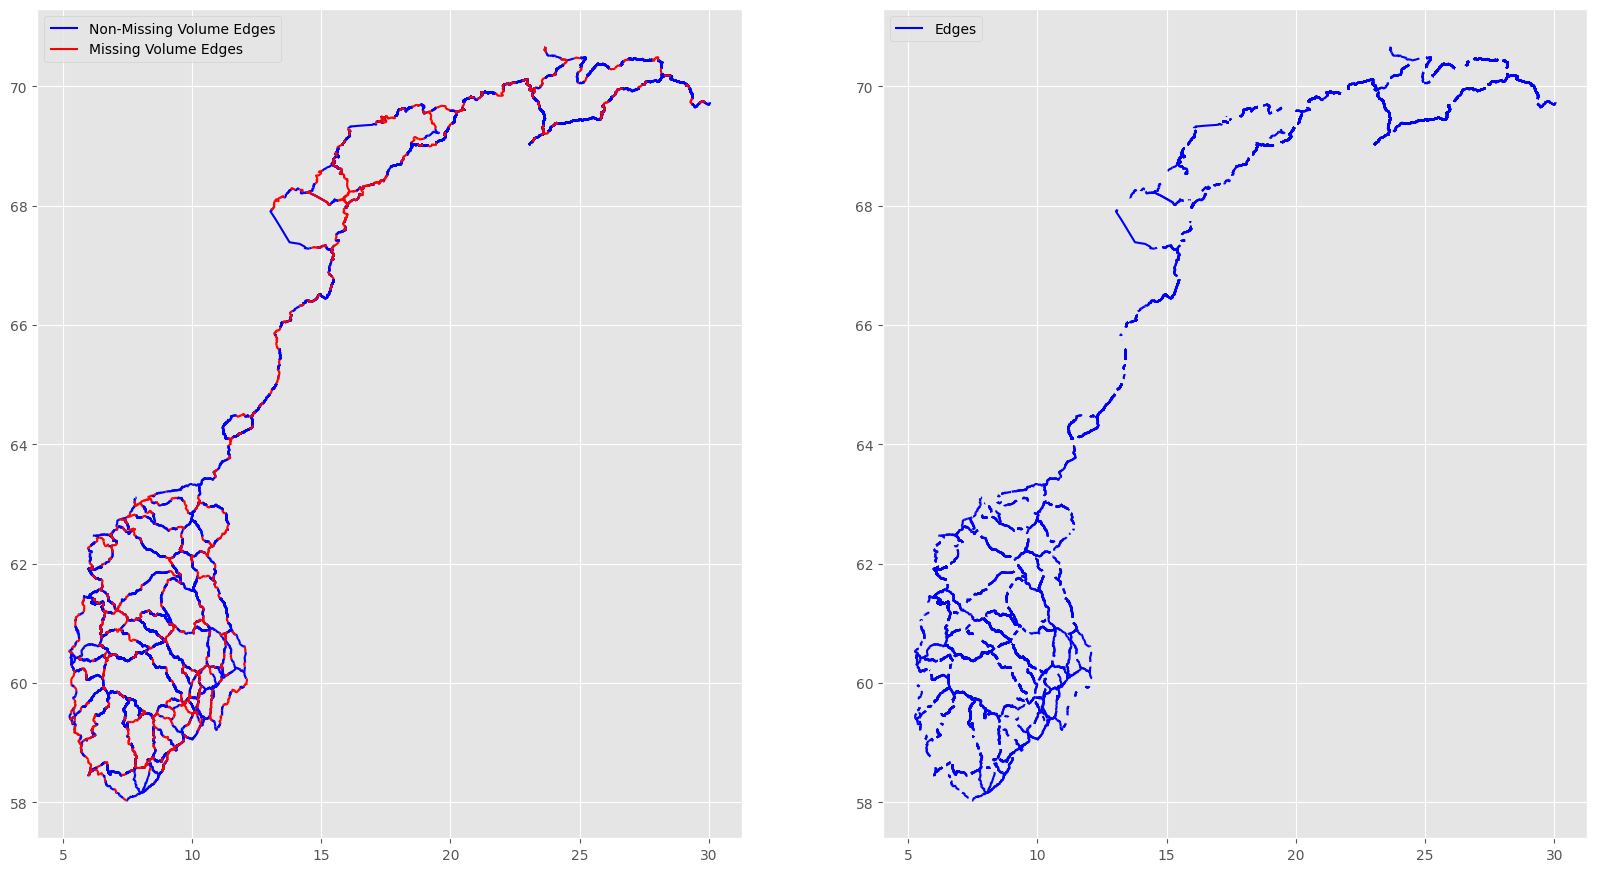

Edges with volume assigned after 4 loop(s) 1642
Edges missing volume after 4 loop(s): 735
Loop 4 threshold = 0.01
--------------------------------------------------------------------------------


100%|██████████| 2122/2122 [04:34<00:00,  7.72it/s]


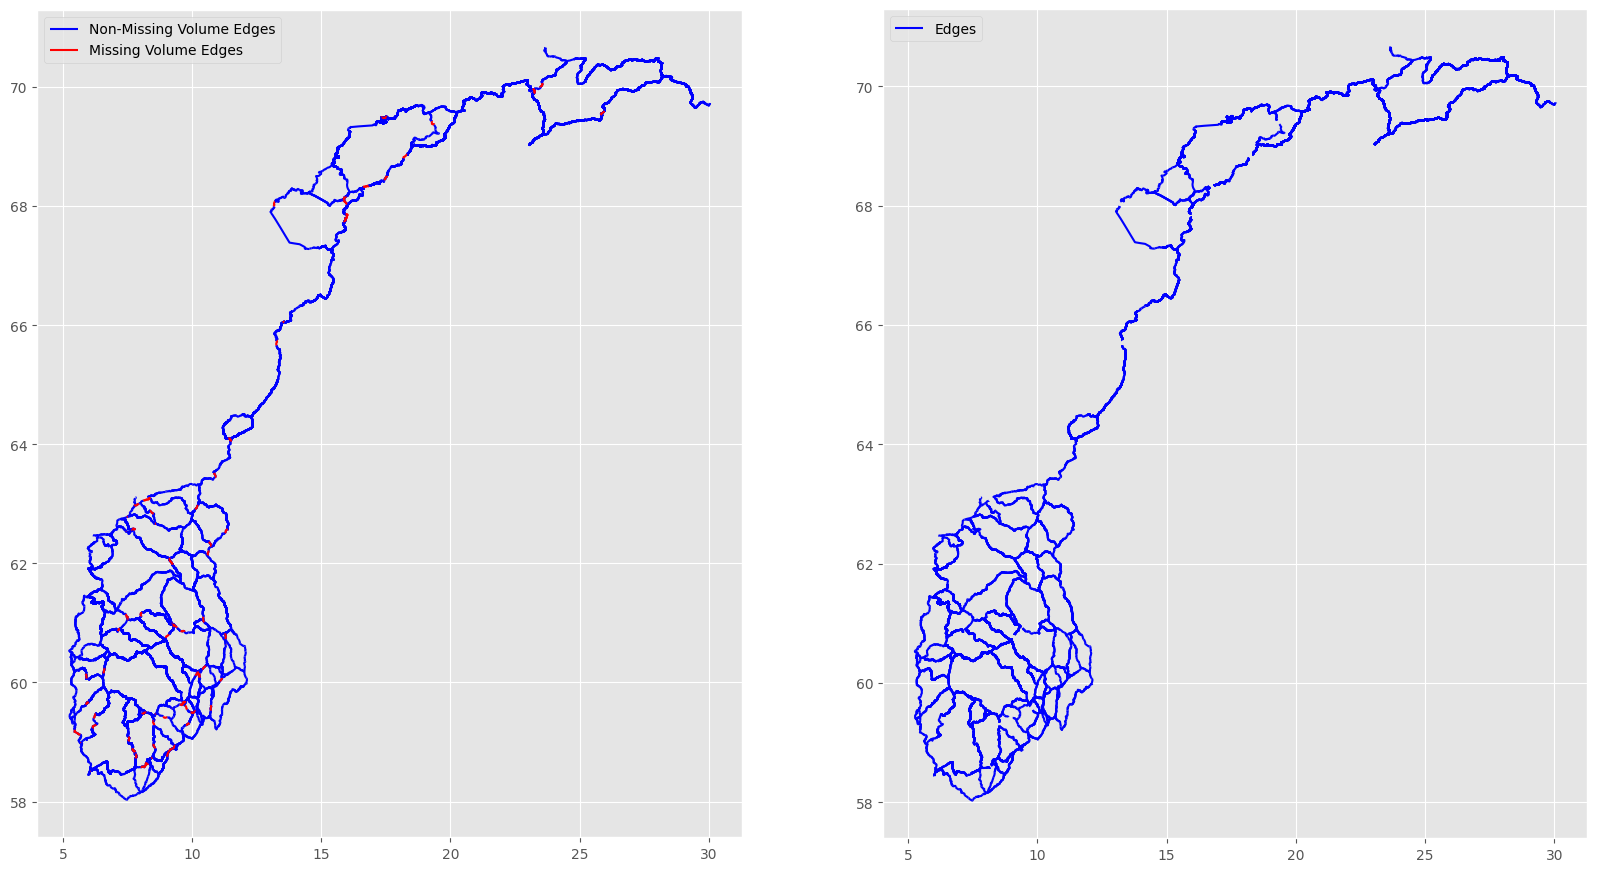

Edges with volume assigned after 5 loop(s) 2255
Edges missing volume after 5 loop(s): 122
Loop 5 threshold = 0.1
--------------------------------------------------------------------------------


100%|██████████| 2122/2122 [04:13<00:00,  8.36it/s]


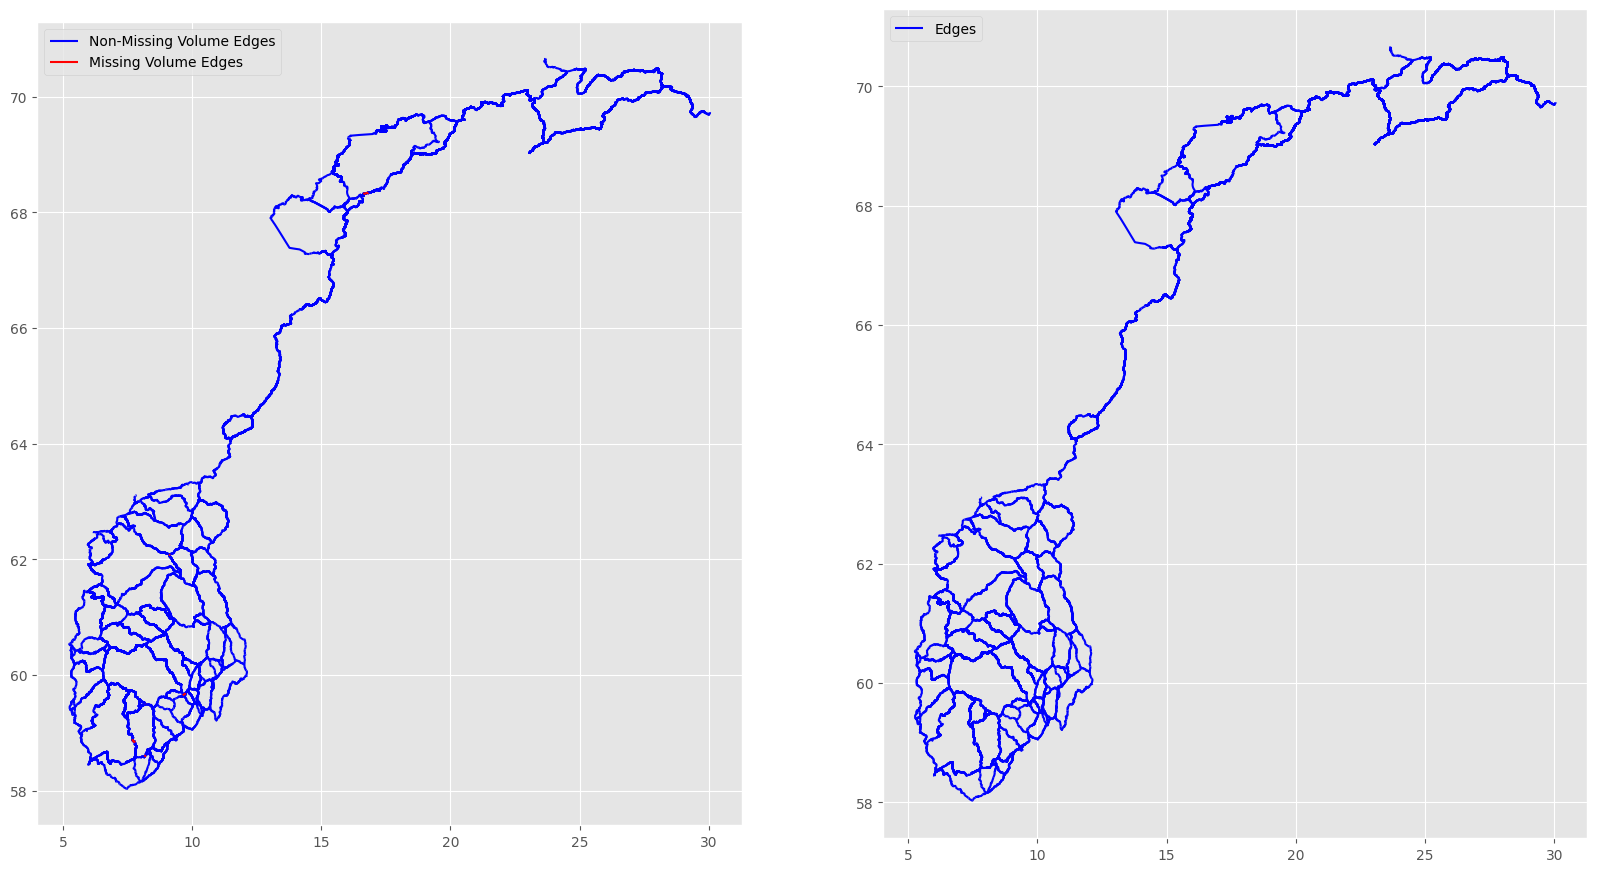

Edges with volume assigned after 6 loop(s) 2365
Edges missing volume after 6 loop(s): 12
Loop 6 threshold = 1
--------------------------------------------------------------------------------


100%|██████████| 2122/2122 [04:06<00:00,  8.62it/s]


In [186]:
# assign_vol_to_edges
F = P.copy()
threshold = 1
threshold_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 100, 500, 1000] # list of thresholds to increasing for each loop (if necessary)
count = 0
edges_with_volume = [edge for edge in F.edges if 'trafficPoint_ID' in F.edges[edge]]

while True:

    threshold_index = min(count, len(threshold_values)-1)
    threshold = threshold_values[threshold_index] + (count - threshold_index) * 100 # If traffic point is outside 1km to edge, the threshold will increase with 100m untill one edge is found.

    assign_vol_to_edges(trafficPoints_gdf, F, threshold=threshold, exclude_edges=edges_with_volume)

    # Find the edges that have volume assigned
    edges_with_volume = [edge for edge in F.edges if 'trafficPoint_ID' in F.edges[edge]]

    # Check if all edges have volume data assigned
    if len(edges_with_volume) == len(F.edges):
        break
    
    # Store node attributes in a dictionary
    node_attrs = {}
    for node, attrs in F.nodes(data=True):
        node_attrs[node] = attrs

    # Create a DataFrame from the node attributes
    new_nodes_df = pd.DataFrame.from_dict(node_attrs, orient='index')

    # Store edge attributes in a dictionary
    edge_attrs = {}
    for source, target, attrs in F.edges(data=True):
        edge_attrs[(source, target)] = attrs

    # Create a DataFrame from the edge attributes
    new_edges_df = pd.DataFrame.from_dict(edge_attrs, orient='index')

    # create geometry points from x and y columns
    geometry = [Point(xy) for xy in zip(new_nodes_df['x'], new_nodes_df['y'])]
    # add geometry column to dataframe
    new_nodes_df['geometry'] = geometry
    new_nodes_gdf = gpd.GeoDataFrame(new_nodes_df, geometry="geometry")
    new_edges_gdf = gpd.GeoDataFrame(new_edges_df, geometry="geometry")
    new_nodes_gdf.crs = {'init': 'epsg:4326'}
    new_edges_gdf.crs = {'init': 'epsg:4326'}

    pivoted_df = trafficPoints_gdf.pivot(index=['art_id', 'id'], columns='month', values=['volume'])#, 'volume_heading1', 'volume_heading2']) #, aggfunc='sum')      # Get volume and months
    result_df = pd.merge(new_edges_gdf, pivoted_df, how = 'left', left_on='trafficPoint_ID', right_on='id')
    result_df = result_df.rename(columns={1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'okt', 11: 'nov', 12: 'des'})

    # Set the size of the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

    plt.style.use('ggplot')

    # Split the edges into two DataFrames for red and blue edges
    red_edges_df = result_df[pd.isnull(result_df['trafficPoint_ID'])]
    blue_edges_df = result_df[~pd.isnull(result_df['trafficPoint_ID'])]

    # Plot the first graph on the first subplot
    #new_nodes_gdf.plot(ax=ax1, color='black', markersize=3, label='Nodes')
    #traffic_counts.plot(ax=ax1, color='green', markersize=5, label='Traffic Points')
    blue_edges_df.plot(ax=ax1, color='blue', label='Non-Missing Volume Edges')
    red_edges_df.plot(ax=ax1, color='red', label='Missing Volume Edges')

    # Filter the edges DataFrame to include only rows where "volume" is not null
    new_edges_df_filtered = result_df.loc[~pd.isnull(result_df['trafficPoint_ID'])]

    # Plot the filtered second graph on the second subplot
    #new_nodes_gdf.plot(ax=ax2, color='red', markersize=5, label='Nodes')
    #traffic_counts.plot(ax=ax2, color='green', markersize=5, label='Traffic Points')
    new_edges_df_filtered.plot(ax=ax2, color='blue', label='Edges')

    # Add a legend for the first plot
    ax1.legend(loc = 'upper left')

    # Add a legend for the second plot in the top left corner
    ax2.legend(loc='upper left')

    # Show the plots
    plt.show()

    count += 1  # increment the count by 1 with each iteration

    # Find the edges that have volume assigned
    edges_with_volume = [edge for edge in F.edges if 'trafficPoint_ID' in F.edges[edge]]
    print('Edges with volume assigned after', count, 'loop(s)', len(edges_with_volume))
    # Find the edges that do not have volume assigned
    edges_without_volume = [edge for edge in F.edges if 'trafficPoint_ID' not in F.edges[edge]]
    print('Edges missing volume after', count, 'loop(s):', len(edges_without_volume))
    print('Loop', count, 'threshold =', threshold)
    print('--------------------------------------------------------------------------------')

    # Increase the threshold by 10 for the next iteration
    #threshold += 100

In [123]:
def assign_vol_to_edges_withPlot(points_df, N, threshold_values): # Plotting-part cause an error
    
    count = 0
    while True:

        edges_with_volume = [edge for edge in F.edges if 'trafficPoint_ID' in F.edges[edge]]
        threshold_index = min(count, len(threshold_values)-1)
        threshold = threshold_values[threshold_index] + (count - threshold_index) * 100 # If traffic point is outside of range in list, the threshold will increase with 100m every loop untill done. 


        if edges_with_volume is None:
            edges_with_volume = []

        for idx, row in tqdm(points_df.iterrows(), total=points_df.shape[0]):
            point = row['geometry']
            nearest_node = None
            min_distance = float('inf')

            for node in N.nodes:
                x, y = N.nodes[node]['x'], N.nodes[node]['y']
                node_point = Point(x, y)
                distance = point.distance(node_point)
                if distance < min_distance:
                    nearest_node = node
                    min_distance = distance

            nearest_edge = None
            min_distance = float('inf')

            for edge in N.edges:
                if edge in edges_with_volume:
                    continue

                node1 = N.nodes[edge[0]]
                node2 = N.nodes[edge[1]]
                coords = [(node1['x'], node1['y']), (node2['x'], node2['y'])]
                distance = point.distance(LineString(coords))

                if distance < min_distance:
                    nearest_edge = edge
                    min_distance = distance

            if min_distance < threshold:
                edge_attrs = {}
                edge_attrs['trafficPoint_ID'] = row['id']
                N.edges[nearest_edge].update(edge_attrs)

            # Store node attributes in a dictionary
        node_attrs = {}
        for node, attrs in F.nodes(data=True):
            node_attrs[node] = attrs

        # Create a DataFrame from the node attributes
        new_nodes_df = pd.DataFrame.from_dict(node_attrs, orient='index')

        # Store edge attributes in a dictionary
        edge_attrs = {}
        for source, target, attrs in F.edges(data=True):
            edge_attrs[(source, target)] = attrs


        # Create a DataFrame from the edge attributes
        new_edges_df = pd.DataFrame.from_dict(edge_attrs, orient='index')

        # create geometry points from x and y columns
        geometry = [Point(xy) for xy in zip(new_nodes_df['x'], new_nodes_df['y'])]
        # add geometry column to dataframe
        new_nodes_df['geometry'] = geometry
        new_nodes_gdf = gpd.GeoDataFrame(new_nodes_df, geometry="geometry")
        new_edges_gdf = gpd.GeoDataFrame(new_edges_df, geometry="geometry")
        new_nodes_gdf.crs = {'init': 'epsg:4326'}
        new_edges_gdf.crs = {'init': 'epsg:4326'}

        pivoted_df = points_df.pivot(index=['art_id', 'id'], columns='month', values=['volume'])#, 'volume_heading1', 'volume_heading2']) #, aggfunc='sum')      # Get volume and months
        result_df = pd.merge(new_edges_gdf, pivoted_df, how = 'left', left_on='trafficPoint_ID', right_on='id')
        result_df = result_df.rename(columns={1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'okt', 11: 'nov', 12: 'des'})

        # Set the size of the plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

        plt.style.use('ggplot')

        # Split the edges into two DataFrames for red and blue edges
        red_edges_df = result_df[pd.isnull(result_df['trafficPoint_ID'])]
        blue_edges_df = result_df[~pd.isnull(result_df['trafficPoint_ID'])]

        # Plot the first graph on the first subplot
        #new_nodes_gdf.plot(ax=ax1, color='black', markersize=3, label='Nodes')
        #points_df.plot(ax=ax1, color='green', markersize=5, label='Traffic Points')
        blue_edges_df.plot(ax=ax1, color='blue', label='Non-Missing Volume Edges')
        red_edges_df.plot(ax=ax1, color='red', label='Missing Volume Edges')

        # Filter the edges DataFrame to include only rows where "volume" is not null
        new_edges_df_filtered = result_df.loc[~pd.isnull(result_df['trafficPoint_ID'])]
        # Plot the filtered second graph on the second subplot
        new_nodes_gdf.plot(ax=ax2, color='red', markersize=5, label='Nodes')
        points_df.plot(ax=ax2, color='green', markersize=5, label='Traffic Points')
        new_edges_df_filtered.plot(ax=ax2, color='blue', label='Edges')

        # Add a legend for the first plot
        ax1.legend(loc = 'upper left')

        # Add a legend for the second plot in the top left corner
        ax2.legend(loc='upper left')

        # Show the plots
        plt.show()

        count += 1  # increment the count by 1 with each iteration

        # Find the edges that have volume assigned
        edges_with_volume = [edge for edge in F.edges if 'trafficPoint_ID' in F.edges[edge]]
        print('Edges with volume assigned after', count, 'loop(s)', len(edges_with_volume))
        # Find the edges that do not have volume assigned
        edges_without_volume = [edge for edge in F.edges if 'trafficPoint_ID' not in F.edges[edge]]
        print('Edges missing volume after', count, 'loop(s):', len(edges_without_volume))
        print('Loop', count, 'threshold =', threshold)
        print('--------------------------------------------------------------------------------')

        plt.close()

        # Check if all edges have volume data assigned
        if len(edges_with_volume) == len(F.edges):
            display(new_nodes_gdf.head())
            display(new_edges_gdf.head())
            break

In [ ]:
# (Somehting wrong with the plotting-part of this function)
#threshold_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 100, 500, 1000] # list of thresholds to increasing for each loop (if necessary)
#assign_vol_to_edges_withPlot(trafficPoints_gdf, F, threshold_values=threshold_list)

Diplay the network in node and edge geodataframes - notice the added column *"trafficPoint_ID"* in the edge geodataframe.

In [175]:
display(new_nodes_gdf.head())
display(new_edges_gdf.head())

,x,y,osmid,roadclass,isBridge,isTunnel,elevation,OD,CS,geometry
794436,10.73379,59.90999,794436,0,0,1,2.35100,1,0,POINT (10.73379 59.90999)
1393791,10.56717,59.89733,1393791,0,0,0,14.17200,0,0,POINT (10.56717 59.89733)
1393835,10.55876,59.89575,1393835,0,0,0,13.05400,0,1,POINT (10.55876 59.89575)
1394577,10.44208,59.83406,1394577,0,0,0,106.97200,0,0,POINT (10.44208 59.83406)
1432666,10.30319,59.81131,1432666,0,0,0,239.61700,0,1,POINT (10.30319 59.81131)


id oneway        ref       name  \
794436  1393791   [794436, 1393791]  False      [E18]      [E18]   
        733912     [794436, 733912]  False      [E18]      [E18]   
        1619561   [794436, 1619561]  False  [E6, E18]  [E6, E18]   
        1401590   [794436, 1401590]  False      [E18]      [E18]   
1393791 1393835  [1393791, 1393835]  False      [E18]      [E18]   

                funcroadclass roadclass isFerry isBridge isTunnel  \
794436  1393791           [0]       [0]  [0, 0]   [0, 0]   [1, 0]   
        733912            [0]       [0]  [0, 0]   [0, 0]   [1, 0]   
        1619561           [0]       [0]  [0, 0]   [0, 0]   [1, 0]   
        1401590           [0]       [0]  [0, 0]   [0, 0]   [1, 0]   
1393791 1393835           [0]       [0]  [0, 0]   [0, 0]   [0, 0]   

                     speedlim  drivetime      length  \
794436  1393791  [80, 50, 70]  -89.33512 10185.31013   
        733912       [60, 70]    5.51369  5106.84804   
        1619561      [60, 70]    4.26043  4265.27176   
        1401590      [80, 70]    8.38154  9615.35205   
1393791 1393835          [80]   -6.00000   377.84107   

                                                     length_weight  \
794436  1393791  [484.21732318058076, 67.01337679355969, 13.493...   
        733912   [1139.8229916739772, 126.12112809842714, 305.5...   
        1619561  [1139.8229916739772, 126.12112809842714, 305.5...   
        1401590  [484.21732318058076, 67.01337679355969, 13.493...   
1393791 1393835  [215.6307873118312, 18.997767560151235, 15.172...   

                                                          geometry  \
794436  1393791  LINESTRING (10.72584 59.91130, 10.72495 59.911...   
        733912   LINESTRING (10.77369 59.88062, 10.77318 59.881...   
        1619561  LINESTRING (10.78499 59.90512, 10.78498 59.905...   
        1401590  LINESTRING (10.72584 59.91130, 10.72495 59.911...   
1393791 1393835  LINESTRING (10.56416 59.89672, 10.56053 59.896...   

                                                                 u  \
794436  1393791  [720386, 720387, 1393669, 720391, 720396, 1393...   
        733912   [1692544, 733954, 1692549, 733961, 1692556, 73...   
        1619561  [1259654, 1692454, 1692585, 1619627, 1692591, ...   
        1401590  [734214, 734223, 1401359, 734231, 1401367, 127...   
1393791 1393835  [1393827, 1393801, 1393807, 1393811, 1393819, ...   

                                                                 v  \
794436  1393791  [720386, 720387, 1393669, 720391, 720396, 1393...   
        733912   [1692544, 733954, 1692549, 733961, 1692556, 73...   
        1619561  [1259654, 1692454, 1692585, 1619627, 1692591, ...   
        1401590  [734214, 734223, 1401359, 734231, 1401367, 127...   
1393791 1393835  [1393827, 1393801, 1393835, 1393807, 1393811, ...   

                                                             grade  \
794436  1393791  [0.005, -0.027, -0.008, -0.08, 0.016, 0.007, -...   
        733912   [-0.002, 0.024, 0.004, 0.001, -0.999, -0.007, ...   
        1619561  [-0.002, 0.024, 0.004, 0.001, -0.999, -0.007, ...   
        1401590  [0.005, -0.027, -0.008, -0.08, 0.016, 0.007, 0...   
1393791 1393835          [-0.02, 0.108, 0.018, 0.104, -0.0, 0.005]   

                                                         grade_abs  \
794436  1393791  [0.0, 0.687, 0.254, 0.367, 2.194, 1.202, 1.221...   
        733912   [0.999, 0.064, 0.673, 0.0, 0.06, 0.257, 0.067,...   
        1619561  [0.999, 1.437, 0.258, 0.125, 0.063, 1.516, 11....   
        1401590  [0.12, 1.804, 1.018, 0.192, 0.705, 0.063, 0.12...   
1393791 1393835            [0.0, 0.108, 0.104, 0.018, 0.005, 0.02]   

                 artificial trafficPoint_ID  
794436  1393791           1    17096V443647  
        733912            1   89040V2545188  
        1619561           1   73840V2041694  
        1401590           1    42011V443823  
1393791 1393835           1    53805V444232

### Add volume to edges:
Now that each edge have the traffic point ID, we can merge in the correct volumes.

In [176]:
volume_df = pd.read_csv("/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/TrafficVolume/data/all_road_volume_org.csv")
volume_df = volume_df[['id', 'name', 'month', 'volume']] # select columns of interest
volume_df.drop_duplicates(subset=['id', 'month'], inplace=True) # remove duplicates
volume_df_pivoted = volume_df.pivot(index='id', columns='month', values='volume') # pivot the data
volume_df_pivoted

month,1,2,3,4,5,6,7,8,9,10,11,12
id,,,,,,,,,,,,
00000V1702725,10002.00000,9596.00000,9765.00000,10333.00000,10260.00000,11587.00000,10288.00000,11123.00000,10266.00000,10855.00000,11788.00000,12356.00000
00000V1702751,35838.00000,34800.00000,33886.00000,39673.00000,40976.00000,44202.00000,42728.00000,42922.00000,39273.00000,40556.00000,40479.00000,37035.00000
00000V1993681,23810.00000,23809.00000,21952.00000,23258.00000,22205.00000,24293.00000,17966.00000,12962.00000,13526.00000,13945.00000,14080.00000,11689.00000
00000V443295,45704.00000,48198.00000,48216.00000,52830.00000,54808.00000,61031.00000,55277.00000,59859.00000,56073.00000,54632.00000,52830.00000,47071.00000
00000V443437,3412.00000,3733.00000,3925.00000,4093.00000,4210.00000,4689.00000,4612.00000,4784.00000,4658.00000,4504.00000,4160.00000,3714.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
99915V578630,2985.00000,3106.00000,3116.00000,3426.00000,3513.00000,3749.00000,3282.00000,3675.00000,3494.00000,3529.00000,3430.00000,3098.00000
99923V578123,176.00000,230.00000,337.00000,204.00000,232.00000,287.00000,384.00000,365.00000,255.00000,219.00000,203.00000,193.00000
99950V704686,1601.00000,1670.00000,1668.00000,1865.00000,2076.00000,2149.00000,1811.00000,2037.00000,2051.00000,1962.00000,1875.00000,1642.00000


In [177]:
new_edges_gdf = pd.merge(new_edges_gdf, volume_df_pivoted, how = 'left', left_on='trafficPoint_ID', right_on='id')
new_edges_gdf

,id,oneway,ref,name,funcroadclass,roadclass,isFerry,isBridge,isTunnel,speedlim,drivetime,length,length_weight,geometry,u,v,grade,grade_abs,artificial,trafficPoint_ID,1,2,3,4,5,6,7,8,9,10,11,12
0,"[794436, 1393791]",False,[E18],[E18],[0],[0],"[0, 0]","[0, 0]","[1, 0]","[80, 50, 70]",-89.33512,10185.31013,"[484.21732318058076, 67.01337679355969, 13.493...","LINESTRING (10.72584 59.91130, 10.72495 59.911...","[720386, 720387, 1393669, 720391, 720396, 1393...","[720386, 720387, 1393669, 720391, 720396, 1393...","[0.005, -0.027, -0.008, -0.08, 0.016, 0.007, -...","[0.0, 0.687, 0.254, 0.367, 2.194, 1.202, 1.221...",1,17096V443647,18005.00000,18206.00000,16765.00000,18667.00000,18222.00000,20156.00000,13511.00000,20114.00000,19555.00000,19197.00000,21483.00000,17507.00000
1,"[794436, 733912]",False,[E18],[E18],[0],[0],"[0, 0]","[0, 0]","[1, 0]","[60, 70]",5.51369,5106.84804,"[1139.8229916739772, 126.12112809842714, 305.5...","LINESTRING (10.77369 59.88062, 10.77318 59.881...","[1692544, 733954, 1692549, 733961, 1692556, 73...","[1692544, 733954, 1692549, 733961, 1692556, 73...","[-0.002, 0.024, 0.004, 0.001, -0.999, -0.007, ...","[0.999, 0.064, 0.673, 0.0, 0.06, 0.257, 0.067,...",1,89040V2545188,19007.00000,20019.00000,19540.00000,21675.00000,22990.00000,24278.00000,22352.00000,23305.00000,21903.00000,21397.00000,20758.00000,18737.00000
2,"[794436, 1619561]",False,"[E6, E18]","[E6, E18]",[0],[0],"[0, 0]","[0, 0]","[1, 0]","[60, 70]",4.26043,4265.27176,"[1139.8229916739772, 126.12112809842714, 305.5...","LINESTRING (10.78499 59.90512, 10.78498 59.905...","[1259654, 1692454, 1692585, 1619627, 1692591, ...","[1259654, 1692454, 1692585, 1619627, 1692591, ...","[-0.002, 0.024, 0.004, 0.001, -0.999, -0.007, ...","[0.999, 1.437, 0.258, 0.125, 0.063, 1.516, 11....",1,73840V2041694,14026.00000,14501.00000,14077.00000,15034.00000,15110.00000,16271.00000,12407.00000,15289.00000,15422.00000,15399.00000,15816.00000,15123.00000
3,"[794436, 1401590]",False,[E18],[E18],[0],[0],"[0, 0]","[0, 0]","[1, 0]","[80, 70]",8.38154,9615.35205,"[484.21732318058076, 67.01337679355969, 13.493...","LINESTRING (10.72584 59.91130, 10.72495 59.911...","[734214, 734223, 1401359, 734231, 1401367, 127...","[734214, 734223, 1401359, 734231, 1401367, 127...","[0.005, -0.027, -0.008, -0.08, 0.016, 0.007, 0...","[0.12, 1.804, 1.018, 0.192, 0.705, 0.063, 0.12...",1,42011V443823,8169.00000,7936.00000,7789.00000,9019.00000,9445.00000,9866.00000,6065.00000,8866.00000,9139.00000,9003.00000,9189.00000,8312.00000
4,"[1393791, 1393835]",False,[E18],[E18],[0],[0],"[0, 0]","[0, 0]","[0, 0]",[80],-6.00000,377.84107,"[215.6307873118312, 18.997767560151235, 15.172...","LINESTRING (10.56416 59.89672, 10.56053 59.896...","[1393827, 1393801, 1393807, 1393811, 1393819, ...","[1393827, 1393801, 1393835, 1393807, 1393811, ...","[-0.02, 0.108, 0.018, 0.104, -0.0, 0.005]","[0.0, 0.108, 0.104, 0.018, 0.005, 0.02]",1,53805V444232,76071.00000,79092.00000,78014.00000,79910.00000,74789.00000,NaN,NaN,NaN,44310.00000,84244.00000,76178.00000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2372,"[995840, 326704]",False,[Tanafjordveien],[Tanafjordveien],[3],[3],"[0, 0]","[0, 0]","[0, 0]",[80],10.77054,11776.58656,"[86.1093107331496, 13.304357889576902, 183.632...","LINESTRING (27.93422 70.46464, 27.93431 70.464...","[995840, 995712, 995720, 1029131, 995730, 9957...","[995712, 995720, 1029131, 995730, 995752, 9957...","[0.046, -0.307, -0.036, 0.006, -0.006, 0.007, ...","[0.307, 0.472, 0.27, 0.065, 0.303, 0.053, 0.04...",1,14490V930350,251.00000,305.00000,342.00000,367.00000,438.00000,554.00000,858.00000,683.00000,488.00000,361.00000,323.00000,260.00000
2373,"[326704, 1007500]",False,[Tanafjordveien],[Tanafjordveien],[3],[3],"[0, 0]","[0, 0]","[0, 0]","[80, 50, 60, 70]",9.77182,10067.55246,"[286.6144894274362, 260.82762951414014, 439.02...","LINESTRING (28.04195 70.43035, 28.04080 70.429...","[1007746, 1102210, 1008008

**This may be more accurate:**

In [181]:
finalJoinedAll = gpd.read_file('/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/1_DataToFinalNetwork/final_joined_all.geojson')
finalJoinedAll = finalJoinedAll.drop(columns = ['volume', 'n'])
finalJoinedAll

,source,target,oneway,ref,name,roadclass,drivetime,length,artificial,id_2,lat,lon,distance,feature_x,feature_y,nearest_x,nearest_y,geometry
0,794436,1393791,False,[E18],[E18],[0],-89.33512,10185.31013,True,33438V444232,59.90166,10.59024,0.00004,10.59025,59.90162,10.59024,59.90166,"LINESTRING (10.726 59.911, 10.725 59.911, 10.7..."
1,794436,733912,False,[E18],[E18],[0],5.51369,5106.84804,True,59192V1878201,59.90562,10.75322,0.00000,10.75322,59.90562,10.75322,59.90562,"LINESTRING (10.774 59.881, 10.773 59.881, 10.7..."
2,794436,1619561,False,"[E6, E18]","[E6, E18]",[0],4.26043,4265.27176,True,59192V1878201,59.90562,10.75322,0.00000,10.75322,59.90562,10.75322,59.90562,"LINESTRING (10.785 59.905, 10.785 59.905, 10.7..."
3,794436,1401590,False,[E18],[E18],[0],8.38154,9615.35205,True,74031V1857387,59.91197,10.63296,0.00004,10.63297,59.91193,10.63296,59.91197,"LINESTRING (10.726 59.911, 10.725 59.911, 10.7..."
4,1393791,1393835,False,[E18],[E18],[0],-6.00000,377.84107,True,53805V444232,59.89574,10.55839,0.00006,10.55840,59.89568,10.55839,59.89574,"LINESTRING (10.564 59.897, 10.561 59.896, 10.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2384,995840,326704,False,[Tanafjordveien],[Tanafjordveien],[3],10.77054,11776.58656,True,14490V930350,70.08836,25.21834,0.00009,27.99252,70.47796,27.99250,70.47804,"LINESTRING (27.934 70.465, 27.934 70.465, 27.9..."
2385,326704,1007500,False,[Tanafjordveien],[Tanafjordveien],[3],9.77182,10067.55246,True,14490V930350,70.08836,25.21834,0.00145,28.08249,70.42628,28.08291,70.42767,"LINESTRING (28.042 70.430, 28.041 70.430, 28.0..."
2386,1007500,1594521,False,[Tanafjordveien],[Tanafjordveien],[3],10.72487,10811.91628,True,14490V930350,70.08836,25.21834,0.00008,28.17689,70.34427,28.17697,70.34429,"LINESTRING (28.191 70.393, 28.190 70.391, 28.1..."
2387,1594521,1181284,False,[Tanafjordveien],[Tanafjordveien],[3],9.69864,10268.18018,True,14490V930350,70.08836,25.21834,0.00021,28.14614,70.25756,28.14593,70.25754,"LINESTRING (28.155 70.299, 28.154 70.298, 28.1..."


In [182]:
volume_gdf = pd.merge(finalJoinedAll, volume_df_pivoted, how = 'left', left_on='id_2', right_on='id')
volume_gdf

,source,target,oneway,ref,name,roadclass,drivetime,length,artificial,id_2,lat,lon,distance,feature_x,feature_y,nearest_x,nearest_y,geometry,1,2,3,4,5,6,7,8,9,10,11,12
0,794436,1393791,False,[E18],[E18],[0],-89.33512,10185.31013,True,33438V444232,59.90166,10.59024,0.00004,10.59025,59.90162,10.59024,59.90166,"LINESTRING (10.726 59.911, 10.725 59.911, 10.7...",81453.00000,84664.00000,82966.00000,91080.00000,92009.00000,99651.00000,83635.00000,97859.00000,94492.00000,93544.00000,91913.00000,82071.00000
1,794436,733912,False,[E18],[E18],[0],5.51369,5106.84804,True,59192V1878201,59.90562,10.75322,0.00000,10.75322,59.90562,10.75322,59.90562,"LINESTRING (10.774 59.881, 10.773 59.881, 10.7...",34276.00000,35539.00000,35016.00000,38122.00000,37843.00000,41610.00000,30198.00000,38625.00000,38102.00000,39098.00000,38699.00000,33801.00000
2,794436,1619561,False,"[E6, E18]","[E6, E18]",[0],4.26043,4265.27176,True,59192V1878201,59.90562,10.75322,0.00000,10.75322,59.90562,10.75322,59.90562,"LINESTRING (10.785 59.905, 10.785 59.905, 10.7...",34276.00000,35539.00000,35016.00000,38122.00000,37843.00000,41610.00000,30198.00000,38625.00000,38102.00000,39098.00000,38699.00000,33801.00000
3,794436,1401590,False,[E18],[E18],[0],8.38154,9615.35205,True,74031V1857387,59.91197,10.63296,0.00004,10.63297,59.91193,10.63296,59.91197,"LINESTRING (10.726 59.911, 10.725 59.911, 10.7...",6013.00000,5942.00000,5623.00000,6443.00000,6235.00000,6926.00000,3681.00000,6338.00000,6295.00000,6464.00000,6716.00000,5346.00000
4,1393791,1393835,False,[E18],[E18],[0],-6.00000,377.84107,True,53805V444232,59.89574,10.55839,0.00006,10.55840,59.89568,10.55839,59.89574,"LINESTRING (10.564 59.897, 10.561 59.896, 10.5...",76071.00000,79092.00000,78014.00000,79910.00000,74789.00000,NaN,NaN,NaN,44310.00000,84244.00000,76178.00000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2384,995840,326704,False,[Tanafjordveien],[Tanafjordveien],[3],10.77054,11776.58656,True,14490V930350,70.08836,25.21834,0.00009,27.99252,70.47796,27.99250,70.47804,"LINESTRING (27.934 70.465, 27.934 70.465, 27.9...",251.00000,305.00000,342.00000,367.00000,438.00000,554.00000,858.00000,683.00000,488.00000,361.00000,323.00000,260.00000
2385,326704,1007500,False,[Tanafjordveien],[Tanafjordveien],[3],9.77182,10067.55246,True,14490V930350,70.08836,25.21834,0.00145,28.08249,70.42628,28.08291,70.42767,"LINESTRING (28.042 70.430, 28.041 70.430, 28.0...",251.00000,305.00000,342.00000,367.00000,438.00000,554.00000,858.00000,683.00000,488.00000,361.00000,323.00000,260.00000
2386,1007500,1594521,False,[Tanafjordveien],[Tanafjordveien],[3],10.72487,10811.91628,True,14490V930350,70.08836,25.21834,0.00008,28.17689,70.34427,28.17697,70.34429,"LINESTRING (28.191 70.393, 28.190 70.391, 28.1...",251.00000,305.00000,342.00000,367.00000,438.00000,554.00000,858.00000,683.00000,488.00000,361.00000,323.00000,260.00000
2387,1594521,1181284,False,[Tanafjordveien],[Tanafjordveien],[3],9.69864,10268.18018,True,14490V930350,70.08836,25.21834,0.00021,28.14614,70.25756,28.14593,70.25754,"LINESTRING (28.155 70.299, 28.154 70.298, 28.1...",251.00000,305.00000,342.00000,367.00000,438.00000,554.00000,858.00000,683.00000,488.00000,361.00000,323.00000,260.00000


## Store GeoDataframes:

In [183]:
# convert the dataframe to CSV
# Edge:
volume_gdf.to_csv('/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/3_outputFromNetworkModelling/edgesgdf_finalVolume_gdf.csv', index=False) # specify the filename and set index=False to exclude the index from the output

# Node:
